In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import lmdb

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset

from torch.autograd import Variable
from torch.autograd import Function
from torch.autograd import gradcheck

import torchvision
import torchvision.transforms as transforms

CUDA_DEVICE = 2

In [2]:
class HR_dataset(Dataset):
    def __init__(self, validation=False, size=500):
        self.val = validation
        self.size = size # Нужен для создания валидационной картинки - центральный кроп
        
        self.data = torchvision.datasets.ImageFolder('RandomDset_1/')  # датасет состоит из разных 
                                                                       # картинок с разным масштабом сцены
                                                                       # - AUGMENTATION #0'''
        self.validationData = torchvision.datasets.ImageFolder('HR_dataset/')
        self.totensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        ])
        
        self.recover = transforms.Compose([
            transforms.Normalize(mean=[ 0., 0., 0. ],
                                 std=[ 1/0.229, 1/0.224, 1/0.225 ]),
            transforms.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                                 std=[ 1., 1., 1. ]),
        ])
    
    def downscale(self, image, downscale_ratio):

        size = image.size[1], image.size[0]
        dr = downscale_ratio
        new_size = int(size[0] // dr), int(size[1] // dr)
        
        # Сжатие
        method = int(1 + 3*np.random.sample())                        # - Уменьшение картинки рандомным методом
        downscale = transforms.Resize(new_size, interpolation=method) # - AUGMENTATION #1
        upscale = transforms.Resize(size, interpolation=2)
        
        image = downscale(image)
        
        small_image = self.totensor(image)
        image = self.totensor(upscale(image))
        return image, small_image
    
    def get(self, idx):
        
        if self.val == True:
            image, _ = self.validationData.__getitem__(idx)
        else:
            image, _ = self.data.__getitem__(idx)
        
        size = image.size[1], image.size[0]
        downscale_ratio = (2 + 0.5 * int(4.4 * np.random.sample()))
        
        if self.val == False and min(size) > 500:
            size = self.size
            crop = transforms.RandomCrop(size) # обрезка - небольшой размер для бОльшего размера батча
            image = crop(image)
            size = image.size[1], image.size[0]
            
        hr_image = self.totensor(image)
        
        inter_lr_image, small_lr_image = self.downscale(image, downscale_ratio)
        
        return small_lr_image, inter_lr_image, hr_image, downscale_ratio
    
    def show(self, idx):
        small, lr, hr, dr = self.get(idx)
#         images = small, lr, hr
        images = self.recover(hr), self.recover(small), self.recover(lr)
        labels = ['High Resolution', 'Low Resolution', 'Interpolated']
        fig = plt.figure(figsize=(20, 6))
        fig.suptitle('Downscale ratio = {}'.format(dr), size=15)
        for it, image in enumerate(images):
            image = np.asarray(image)
            label = labels[it]
            pic = fig.add_subplot(1, 3, it+1)
            pic.set_title('{}:'.format(label))
            pic.imshow(np.transpose(image, (1, 2, 0)))
        
    
    def __getitem__(self, idx):
        _, lr_image, hr_image, _ = self.get(idx)
        return lr_image, hr_image
    
    def __len__(self):
        if self.val:
            return self.validationData.__len__()
        else:
            return self.data.__len__()

In [3]:
train_dataset = HR_dataset()
valid_dataset = HR_dataset(validation=True, size=100)

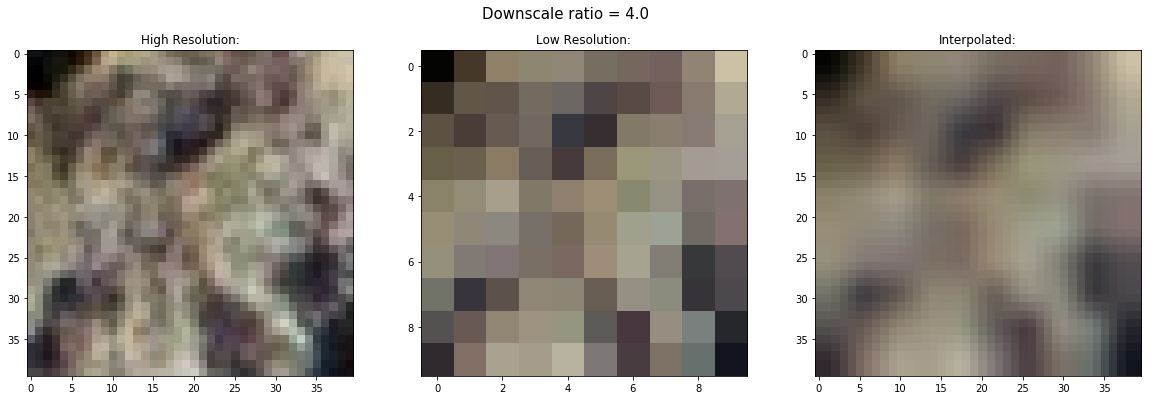

In [14]:
train_dataset.show(1050)

In [5]:
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self, kernel=3):
        super(Conv_ReLU_Block, self).__init__()
        kernel = 3
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel, stride=1, padding=int((kernel-1)/2), bias=False)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class Net(nn.Module):
    def __init__(self, num_of_layers=18):
        super(Net, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, num_of_layers)
        self.input = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        kernel_size = 3
        for num in range(num_of_layer):
            layers.append(block(kernel=3*(num+1)))
        return nn.Sequential(*layers)

    def forward(self, x):
#         print("Size {}".format(x.size()))
#         print("Size {}".format(x.size()))
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out

In [6]:
from math import log10

def single_evaluate_and_show(sample):
    input = Variable(sample[0].unsqueeze(0).cuda(CUDA_DEVICE))
    target = Variable(sample[1].unsqueeze(0).cuda(CUDA_DEVICE))
    prediction = model(input) 
    mse_i = criterion(input, target)
    mse_m = criterion(prediction, target)
    psnr_i = 10 * log10(1 / mse_i)
    psnr_m = 10 * log10(1 / mse_m)
    
    result = (target, input, prediction)
    fig = plt.figure(figsize=(8, 20))
    plots = []
    for idx, image in enumerate(result, 1):
        image = image.data.squeeze(0)
        invert = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                            std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                          std = [ 1., 1., 1. ]),
                                    ])
        image = invert(image)
        image = np.asarray(image)
        plots.append(fig.add_subplot(3, 1, idx))
        plots[idx-1].imshow((np.transpose(image, (1, 2, 0))))
    print("Inter PSNR: {:.4f} dB".format(psnr_i))
    print("Model PSNR: {:.4f} dB".format(psnr_m))
    
def validation(model):
    input, target = valid_dataset.__getitem__(0)
    input, target = Variable(input.unsqueeze(0)).cuda(CUDA_DEVICE), Variable(target.unsqueeze(0)).cuda(CUDA_DEVICE)
    input = model(input)
    return criterion(input, target)

In [7]:
def train(training_data_loader, model, optimizer, criterion, epoch, lr):

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))
    loss_acc = 0
    loss_acc_return = 0
    for iteration, batch in enumerate(training_data_loader, 1):

        input, target = Variable(batch[0].cuda(CUDA_DEVICE)), Variable(batch[1].cuda(CUDA_DEVICE))

        loss = criterion(model(input), target)
        loss_acc += loss
        loss_acc_return += loss
        optimizer.zero_grad()
        loss.backward()
        
        max_grad_norm = 0.1 / lr
        nn.utils.clip_grad_norm(model.parameters(),max_grad_norm) 
        
        optimizer.step()

        
        show_every = 100

        if iteration % show_every == 0:
            loss_show = loss_acc / show_every
            loss_acc = 0
            print("===> Epoch[{}]({}/{}): Loss: {:.10f} ".format(epoch, iteration, len(training_data_loader), loss_show))
        
    return loss_acc_return / 1090

In [8]:
model = Net(num_of_layers=18).cuda(CUDA_DEVICE)
a = model.train()

In [9]:
train_dataset = HR_dataset(size=40)
valid_dataset = HR_dataset(validation=True, size=100)

criterion = nn.MSELoss().cuda(CUDA_DEVICE)

In [10]:
lr = 0.1
minibatch_size = 1

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True, num_workers=2)
single_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=False, weight_decay=0.0001)

In [11]:
import warnings; warnings.simplefilter('ignore')
loss = []
for epoch in range(20):
    if epoch%1==0:
        val_res = validation(model)
        print("Validation: {}".format(val_res))
    l = train(train_loader, model, optimizer, criterion, epoch, lr)
    loss.append(l)
    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
ax.clear()
ax.plot(loss)

Validation: 0.8009895086288452
Epoch = 0, lr = 0.1
===> Epoch[0](100/1084): Loss: 0.1128908917 
===> Epoch[0](200/1084): Loss: 0.0820227787 
===> Epoch[0](300/1084): Loss: 0.0843496174 
===> Epoch[0](400/1084): Loss: 0.0837014765 
===> Epoch[0](500/1084): Loss: 0.0832344741 
===> Epoch[0](600/1084): Loss: 0.0976946503 
===> Epoch[0](700/1084): Loss: 0.0913529769 
===> Epoch[0](800/1084): Loss: 0.0873880684 
===> Epoch[0](900/1084): Loss: 0.0804045275 
===> Epoch[0](1000/1084): Loss: 0.1037632748 
Validation: 0.5122128129005432
Epoch = 1, lr = 0.1
===> Epoch[1](100/1084): Loss: 0.0666553080 
===> Epoch[1](200/1084): Loss: 0.0781150162 
===> Epoch[1](300/1084): Loss: 0.1103691682 
===> Epoch[1](400/1084): Loss: 0.0659956783 
===> Epoch[1](500/1084): Loss: 0.1308520138 
===> Epoch[1](600/1084): Loss: 0.0994873047 
===> Epoch[1](700/1084): Loss: 0.1034369171 
===> Epoch[1](800/1084): Loss: 0.0676596612 
===> Epoch[1](900/1084): Loss: 0.0925987288 
===> Epoch[1](1000/1084): Loss: 0.09455950

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1525812548180/work/aten/src/THC/generic/THCStorage.cu:58

Validation: 0.3560759723186493
Epoch = 0, lr = 0.1
===> Epoch[0](10/22): Loss: 0.0788482800 
===> Epoch[0](20/22): Loss: 0.0834995732 
Validation: 0.4890647232532501
Epoch = 1, lr = 0.1
===> Epoch[1](10/22): Loss: 0.0807242393 
===> Epoch[1](20/22): Loss: 0.0744448230 
Validation: 0.23488058149814606
Epoch = 2, lr = 0.1
===> Epoch[2](10/22): Loss: 0.0915841684 
===> Epoch[2](20/22): Loss: 0.0706652030 
Validation: 0.45910459756851196
Epoch = 3, lr = 0.1
===> Epoch[3](10/22): Loss: 0.0829971656 
===> Epoch[3](20/22): Loss: 0.0802439079 
Validation: 0.3664083778858185
Epoch = 4, lr = 0.1
===> Epoch[4](10/22): Loss: 0.0802421197 
===> Epoch[4](20/22): Loss: 0.0795348808 
Validation: 0.4649576246738434
Epoch = 5, lr = 0.1
===> Epoch[5](10/22): Loss: 0.0713062361 
===> Epoch[5](20/22): Loss: 0.0803869292 
Validation: 0.5269082188606262
Epoch = 6, lr = 0.1
===> Epoch[6](10/22): Loss: 0.0757015496 
===> Epoch[6](20/22): Loss: 0.0825195611 
Validation: 0.48386889696121216
Epoch = 7, lr = 0.1
=

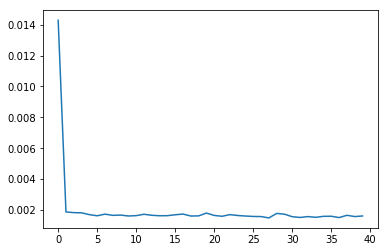

In [62]:
for epoch in range(20):
    if epoch%1==0:
        val_res = validation(model)
        print("Validation: {}".format(val_res))
    l = train(train_loader, model, optimizer, criterion, epoch, lr)
    loss.append(l)
    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
ax.clear()
ax.plot(loss)

Validation: 0.4475041627883911
Epoch = 0, lr = 0.01
===> Epoch[0](10/22): Loss: 0.0870993361 
===> Epoch[0](20/22): Loss: 0.0801820904 
Validation: 0.5274578928947449
Epoch = 1, lr = 0.01
===> Epoch[1](10/22): Loss: 0.0738791749 
===> Epoch[1](20/22): Loss: 0.0857950673 
Validation: 0.25952306389808655
Epoch = 2, lr = 0.01
===> Epoch[2](10/22): Loss: 0.0760507286 
===> Epoch[2](20/22): Loss: 0.0848280564 
Validation: 0.3624313771724701
Epoch = 3, lr = 0.01
===> Epoch[3](10/22): Loss: 0.0806633011 
===> Epoch[3](20/22): Loss: 0.0779987648 
Validation: 0.3680242896080017
Epoch = 4, lr = 0.01
===> Epoch[4](10/22): Loss: 0.0812221989 
===> Epoch[4](20/22): Loss: 0.0851006061 
Validation: 0.24011574685573578
Epoch = 5, lr = 0.01
===> Epoch[5](10/22): Loss: 0.0792850479 
===> Epoch[5](20/22): Loss: 0.0690798089 
Validation: 0.5258398652076721
Epoch = 6, lr = 0.01
===> Epoch[6](10/22): Loss: 0.0669854879 
===> Epoch[6](20/22): Loss: 0.0779445246 
Validation: 0.36706945300102234
Epoch = 7, lr 

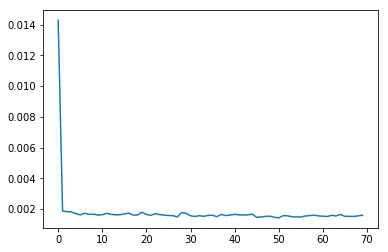

In [63]:
lr /= 10
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=False, weight_decay=0.0001)

for epoch in range(30):
    if epoch%1==0:
        val_res = validation(model)
        print("Validation: {}".format(val_res))
    l = train(train_loader, model, optimizer, criterion, epoch, lr)
    loss.append(l)
    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
ax.clear()
ax.plot(loss)

Validation: 0.24093690514564514
Epoch = 0, lr = 0.001
===> Epoch[0](10/22): Loss: 0.0733689815 
===> Epoch[0](20/22): Loss: 0.0759929940 
Validation: 0.45039889216423035
Epoch = 1, lr = 0.001
===> Epoch[1](10/22): Loss: 0.0798149407 
===> Epoch[1](20/22): Loss: 0.0748630315 
Validation: 0.35996177792549133
Epoch = 2, lr = 0.001
===> Epoch[2](10/22): Loss: 0.0784047693 
===> Epoch[2](20/22): Loss: 0.0728970394 
Validation: 0.5228044986724854
Epoch = 3, lr = 0.001
===> Epoch[3](10/22): Loss: 0.0786516815 
===> Epoch[3](20/22): Loss: 0.0723368376 
Validation: 0.46987468004226685
Epoch = 4, lr = 0.001
===> Epoch[4](10/22): Loss: 0.0746575072 
===> Epoch[4](20/22): Loss: 0.0793346092 
Validation: 0.35932448506355286
Epoch = 5, lr = 0.001
===> Epoch[5](10/22): Loss: 0.0747209713 
===> Epoch[5](20/22): Loss: 0.0741903111 
Validation: 0.3597401976585388
Epoch = 6, lr = 0.001
===> Epoch[6](10/22): Loss: 0.0707898512 
===> Epoch[6](20/22): Loss: 0.0794449076 
Validation: 0.5506962537765503
Epoch

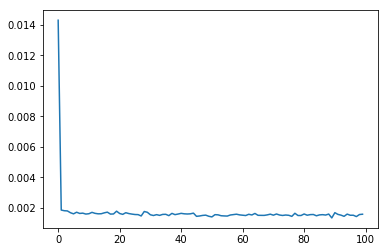

In [64]:
lr /= 10
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=False, weight_decay=0.0001)

for epoch in range(30):
    if epoch%1==0:
        val_res = validation(model)
        print("Validation: {}".format(val_res))
    l = train(train_loader, model, optimizer, criterion, epoch, lr)
    loss.append(l)
    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
ax.clear()
ax.plot(loss)

In [65]:
torch.save(model, '/home/k.taletskiy/10_SuperResolution/vdsr_ms_bs=1')

In [13]:
single_evaluate_and_show(train_dataset.__getitem__(0))

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1525812548180/work/aten/src/THC/generic/THCStorage.cu:58

In [8]:
class testUrbanDset(Dataset):
    def __init__(self):
        super(testUrbanDset, self).__init__()
        self.data = torchvision.datasets.ImageFolder('image_SRF_2')
        self.totensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, idx, crop=False, size=50):
        ccrop = transforms.CenterCrop(size)
        image, _ = self.data.__getitem__(idx)
        if crop:
            image = ccrop(image)
        image = self.totensor(image)
        
        label, _ = self.data.imgs[idx] # метод родительского класса Dataset. Возвращает строку с названием прочитанного файла.
        
        start, end = label.find('2/') + 2, label.find('/img')
        label = label[start:end]
        return image, label
    
    def get_examples(self, idx, crop=False, size=50):
        pics_and_labels = {}
        for i in range(11): # 11 - количество классов в датасете - по количеству методов (подходов)
            index = idx + 100 * i # в каждом классе по 100 картинок
            item = self.__getitem__(index, crop=crop, size=size)
            pics_and_labels.update([(item[1],item[0])])
        return pics_and_labels
    
    def __len__(self):
        return self.data.__len__()

In [9]:
test_dset = testUrbanDset()

def psnr(input, target, cuda=False):
    mse = nn.MSELoss()
    if cuda:
        mse = mse.cuda(CUDA_DEVICE)
    mse = mse(input, target)
    return 10 * log10(1.0 / mse)
#     return None

def print_pics(pics, lr, hr):
    pass

def test_and_compare(model, idx=0, crop=False, size=50):
    model.eval()
    
    recover = transforms.Compose([
        transforms.Normalize(mean=[ 0., 0., 0. ],
                             std=[ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                             std=[ 1., 1., 1. ]),
    ])
    
    pics = test_dset.get_examples(idx, crop=crop, size=size)
    hr = pics.pop('HR')
    lr = pics.pop('LR')
    
    size = hr.size()[1]
    upscale = transforms.Compose([
        transforms.Normalize(mean=[ 0., 0., 0. ],
                             std=[ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                             std=[ 1., 1., 1. ]),
        transforms.ToPILImage(),
        transforms.Resize(size, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ])
    
    upscaled = upscale(lr)
    model_input = Variable(upscaled.unsqueeze(0)).cuda(CUDA_DEVICE)
    target = Variable(hr.unsqueeze(0), requires_grad=False).cuda(CUDA_DEVICE)
    prediction = model(model_input)
    model_psnr = psnr(prediction, target, cuda=True)
    prediction = np.asarray(recover(prediction.squeeze(0)).data)
    
    hr = hr.cuda(CUDA_DEVICE)
    plots = []
    fig = plt.figure(figsize=(70, 80))
    for it, label in enumerate(pics):
#         image = transforms.ToTensor().__call__(pic[0])
        image = recover(pics[label])
        image = np.asarray(image)
        
        metric = psnr(pics[label].cuda(CUDA_DEVICE), hr, cuda=True)
    #         pics_labels_psnr = pics_labels_psnr.append(pic_label_psnr)

        plots.append(fig.add_subplot(12, 1, it+1))
        plots[it].set_title('{}\nPSNR: {:.4f} dB'.format(label, metric))
        plots[it].imshow((np.transpose(image, (1, 2, 0))))
        
    plots.append(fig.add_subplot(12, 1, 10))
    plots[9].set_title('VDSR\nPSNR: {:.4f} dB'.format(model_psnr))
    plots[9].imshow((np.transpose(prediction, (1, 2, 0))))
    
#     plots.append(fig.add_subplot(6, 2, 11))
#     plots[9].set_title('Upscaled')
#     plots[9].imshow((np.transpose(prediction, (1, 2, 0))))

In [8]:
# model = torch.load('/home/k.taletskiy/10_SuperResolution/vdsr_nv')
test_and_compare(model, idx=2, crop=False, size=400)

NameError: name 'test_and_compare' is not defined

In [ ]:
# model = torch.load('/home/k.taletskiy/10_SuperResolution/vdsr_nv')
test_and_compare(model, idx=50, crop=False, size=50)

In [ ]:
# model = torch.load('/home/k.taletskiy/10_SuperResolution/vdsr_nv')
test_and_compare(model, idx=50, crop=False, size=50)

In [20]:
torch.save(model, '/home/k.taletskiy/10_SuperResolution/vdsr_ms_v0_1')

In [83]:
def show(sample):
    model.eval()
    input = sample[1]
    size = input.size()[1]*4
    upscale = transforms.Compose([
        transforms.Normalize(mean=[ 0., 0., 0. ],
                             std=[ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                             std=[ 1., 1., 1. ]),
        transforms.ToPILImage(),
        transforms.Resize(size, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ])
    inp = upscale(sample[1])
    inp = Variable(inp.unsqueeze(0).cuda(CUDA_DEVICE))
    prediction = model(inp)
    
    result = (input, prediction)
    fig = plt.figure(figsize=(8, 20))
    plots = []
    for idx, image in enumerate(result, 1):
        image = image.data.squeeze(0)
        invert = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                            std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                          std = [ 1., 1., 1. ]),
                                    ])
        image = invert(image)
        image = np.asarray(image)
        plots.append(fig.add_subplot(3, 1, idx))
        plots[idx-1].imshow((np.transpose(image, (1, 2, 0))))

In [103]:
valid_dataset = HR_dataset(validation=True, size=100)
show(valid_dataset.__getitem__(0))

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1525812548180/work/aten/src/THC/generic/THCStorage.cu:58